In [8]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

import os
import math
import torch
from scipy.spatial import cKDTree
from train_STAligner import train_STAligner,train_STAGATE
from ST_utils import Cal_Spatial_Net
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/lih0m/STalign/SANTO_revise/STaligner


In [9]:
def find_rigid_transform(A, B):
    assert A.shape == B.shape


    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    A_centered = A - centroid_A
    B_centered = B - centroid_B


    H = A_centered.T @ B_centered

    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def rotation_angle_2d(R):
    theta = np.arctan2(R[1, 0], R[0, 0])
    return np.degrees(theta)
def evaluation(src_cor, tgt_cor, src_exp, tgt_exp, src_cell_type, tgt_cell_type):

    kd_tree = cKDTree(src_cor)
    distances, indices = kd_tree.query(tgt_cor, k=1)
    corr = np.corrcoef(np.concatenate((tgt_exp,src_exp[indices]), axis=0))[:tgt_exp.shape[0],tgt_exp.shape[0]:]
    acc = corr.trace()/tgt_exp.shape[0]
    cri = np.mean((tgt_cell_type == src_cell_type[indices])+0)
    #euc = np.mean((ori_src_cor-src_cor)**2)

    return acc, cri
def simulate_stitching(adata,axis = 0, from_low = True, threshold = 0.5):
    cadata = adata.copy()
    coo = cadata.obsm['spatial']
    scale = np.max(coo[:, axis]) - np.min(coo[:, axis])
    if from_low:
        chosen_indices = coo[:,axis] > (scale * threshold + np.min(coo[:, axis]))
    else:
        chosen_indices = coo[:,axis] < (np.max(coo[:, axis]) - scale * threshold)
    cadata = cadata[chosen_indices,:]
    return cadata
def intersect(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3


------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)


The graph contains 17230 edges, 8506 cells.
2.0256 neighbors per cell on average.


/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)


The graph contains 20400 edges, 9803 cells.
2.0810 neighbors per cell on average.


/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


STAligner(
  (conv1): GATConv(656, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 656, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Train with STAligner...


  0%|          | 0/50 [00:00<?, ?it/s]

Update spot triplets at epoch 500


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


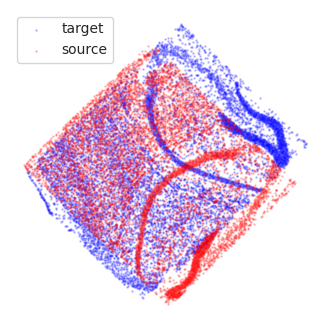

In [14]:
### STARmap PLUS (rotate 45 degree)


adata1 = sc.read_h5ad('../Dataset/8month_cr1_example_align.h5ad')
adata2 = sc.read_h5ad('../Dataset/8month_cr2_example_align.h5ad')

src_cor = np.array(adata1.obsm['spatial'])
tgt_cor = np.array(adata2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[ np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)

adata2.obsm['spatial'] = tgt_cor
adata1.obsm['spatial'] = src_cor
adata2.obs['celltype'] = adata2.obsm['celltype']
adata1.obs['celltype'] = adata1.obsm['celltype']
del adata2.obsm['celltype']
del adata1.obsm['celltype']
Batch_list = []
adj_list = []
section_ids = ['src','tgt']
for adata in [adata1,adata2]:
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']].copy()
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

adata_concat = train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

adata1 = adata_concat[adata_concat.obs.slice_name == 'src',:].copy()
adata2 = adata_concat[adata_concat.obs.slice_name == 'tgt',:].copy()

kd_tree = cKDTree(adata1.obsm['STAligner'])
distances, indices = kd_tree.query(adata2.obsm['STAligner'], k=1)
R,T = find_rigid_transform(adata1.obsm['spatial'][indices],adata2.obsm['spatial'])
pred_angle = rotation_angle_2d(R)
adata1.obsm['align_spatial'] = np.dot(adata1.obsm['spatial'], rotation.T) + T

plt.figure(figsize=(4,4))
plt.scatter(adata2.obsm['spatial'][:,0],adata2.obsm['spatial'][:,1],c='b',label='target',alpha=0.2,s=0.8)
plt.scatter(adata1.obsm['align_spatial'][:,0],adata1.obsm['align_spatial'][:,1],c='r',label='source',alpha=0.2,s=0.8)
plt.axis('off')
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()



/tmp/ipykernel_21700/394528654.py:20: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata1.obsm['spatial'] = src_cor
/tmp/ipykernel_21700/394528654.py:21: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata2.obsm['spatial'] = tgt_cor


------Calculating spatial graph...
The graph contains 198050 edges, 3961 cells.
50.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 202850 edges, 4057 cells.
50.0000 neighbors per cell on average.
STAligner(
  (conv1): GATConv(517, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 517, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Train with STAligner...


  0%|          | 0/50 [00:00<?, ?it/s]

Update spot triplets at epoch 500


100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


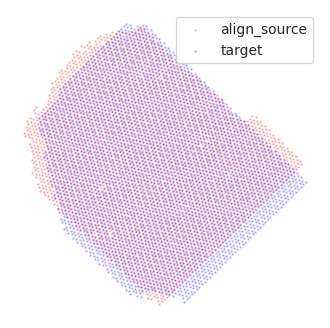

In [16]:
### DLPFC stitching (rotate 45 degree, 80% overlap)

train_ad1 = sc.read_h5ad('../Dataset/151507_preprocessed.h5')
train_ad2 = sc.read_h5ad('../Dataset/151508_preprocessed.h5')
train_ad1.X = np.array(train_ad1.X.todense())
train_ad2.X = np.array(train_ad2.X.todense())

adata1 = simulate_stitching(train_ad1, axis=0, from_low=True, threshold=0.1)
adata2 = simulate_stitching(train_ad2, axis=0, from_low=False, threshold=0.1)
train_ad1_part_overlap_index = adata1.obsm['spatial'][:,0] < np.max(adata2.obsm['spatial'][:,0])
train_ad2_part_overlap_index = adata2.obsm['spatial'][:,0] > np.min(adata1.obsm['spatial'][:,0])

src_cor = np.array(adata1.obsm['spatial'])
tgt_cor = np.array(adata2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)
adata1.obsm['spatial'] = src_cor
adata2.obsm['spatial'] = tgt_cor
Batch_list = []
adj_list = []
section_ids = ['src','tgt']
for adata in [adata1,adata2]:
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']].copy()
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

adata_concat = train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

adata1 = adata_concat[adata_concat.obs.slice_name == 'src',:].copy()
adata2 = adata_concat[adata_concat.obs.slice_name == 'tgt',:].copy()

kd_tree = cKDTree(adata1.obsm['STAligner'])
distances, indices = kd_tree.query(adata2.obsm['STAligner'], k=1)
R,T = find_rigid_transform(adata1.obsm['spatial'][indices],adata2.obsm['spatial'])
pred_angle = rotation_angle_2d(R)
adata1.obsm['align_spatial'] = np.dot(adata1.obsm['spatial'], rotation.T) + T

plt.figure(figsize=(4,4))
plt.scatter(adata1.obsm['align_spatial'][:,0],adata1.obsm['align_spatial'][:,1],c='r',label='align_source',alpha=0.2,s=0.8)
plt.scatter(adata2.obsm['spatial'][:,0],adata2.obsm['spatial'][:,1],c='b',label='target',alpha=0.2,s=0.8)
plt.axis('off')
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 263692 edges, 5279 cells.
49.9511 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 267809 edges, 5361 cells.
49.9550 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 263776 edges, 5284 cells.
49.9198 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 285742 edges, 5726 cells.
49.9025 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 267935 edges, 5381 cells.
49.7928 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 283190 edges, 5676 cells.
49.8925 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 284264 edges, 5693 cells.
49.9322 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 290648 edges, 5818 cells.
49.9567 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 306566 edges, 6135 cells.
49.9700 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 316335 edges, 6328 cells.
49.9897 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 313020 edges, 6263 cells.
49.9792 neighbors per cell on average.
------Calculating spatial graph...


/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/home/lih0m/STalign/SANTO_revise/STaligner/ST_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but 

The graph contains 303727 edges, 6089 cells.
49.8813 neighbors per cell on average.
STAligner(
  (conv1): GATConv(22, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 22, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 10/10 [02:01<00:00, 12.16s/it]


Train with STAligner...


  0%|          | 0/50 [00:00<?, ?it/s]

Update spot triplets at epoch 500


100%|██████████| 50/50 [11:32<00:00, 13.85s/it]  
/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


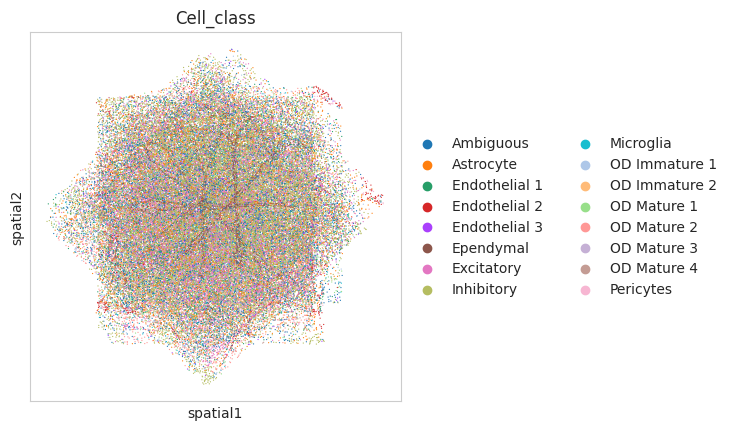

In [18]:
adata = sc.read_h5ad('../Dataset/MERFISH.h5ad')
#adata.obsm['align_spatial'] = adata.obsm['spatial']
slice_ids = np.unique(adata.obs.Bregma)
slice_ids[::-1].sort()
adatas = [adata[adata.obs.Bregma == i,:].copy() for i in slice_ids]
section_ids = slice_ids
Batch_list = []
adj_list = []
df = pd.DataFrame(columns=['pcc','cri'])

for adata in adatas:
    Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=50)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']].copy()

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('str')
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)
adata_concat = train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

for i in range(len(slice_ids)-1):
    adata1 = adata_concat[adata_concat.obs.slice_name == slice_ids[i],:].copy()
    adata2 = adata_concat[adata_concat.obs.slice_name == slice_ids[i+1],:].copy()

    kd_tree = cKDTree(adata2.obsm['STAligner'])
    distances, indices = kd_tree.query(adata1.obsm['STAligner'], k=1)
    R,T = find_rigid_transform(adata2.obsm['spatial'][indices],adata1.obsm['spatial'])
    pred_angle = rotation_angle_2d(R)
    adata_concat.obsm['spatial'][adata_concat.obs.Bregma >= slice_ids[i],:] = np.dot(adata_concat.obsm['spatial'][adata_concat.obs.Bregma >= slice_ids[i],:], rotation.T) + T
sc.pl.spatial(adata_concat,
              basis = 'spatial',
              color='Cell_class',
              spot_size=10)